Imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from math import gcd
import itertools

Square Lattice

In [3]:
class Square_Hamiltonian:
    """ Square lattice simulation with Anderson localization and a magnetic field"""

    def __init__(self, length: int, t: float, W: float, phi: float, q: int):
        """
          Initialize Square_Hamiltonian class.

          Parameters:
              length (int): Lattice size (L x L).
              t (float): Hopping parameter.
              W (float): Disorder parameter.
              phi (float): Magnetic flux per plaquette (in units of flux quantum).
              q (int): Maximum denominator for phi values in Hofstadter butterfly.
          """

        self.L = length  # Lattice dimension
        self.N = self.L * self.L  # Total number of sites
        self.t = t  # Hopping parameter
        self.disorder = W  # Disorder strength
        self.phi = phi  # Magnetic flux per plaquette
        self.max_q = q  # Maximum denominator for phi values
        self.matrix = np.zeros((self.N, self.N), dtype=complex)  # Hamiltonian matrix

        # Initialize on-site disorder potentials
        self.on_site_potential = np.zeros(self.N)

        # Initialize boundary fluxes - these do not contribute to the flux plaquett
        self.phi_x = 0.0  # Flux through x direction
        self.phi_y = 0.0  # Flux through y direction

    """ Defining and diagonalizing the Hamiltonian for the system """

    def disorder_setter(self):
        # Incorporate the disorder parameter into matrix elements as an on-site disorder potential
        self.on_site_potential = self.disorder * (2 * np.random.rand(self.N) - 1)

    def peierls_phase(self, i, j, direction):
        """
        Calculate the Peierls phase for hopping between sites.

        Parameters:
            i (int): x-index of the starting site.
            j (int): y-index of the starting site.
            direction (str): 'x' for horizontal hopping, 'y' for vertical hopping.

        Returns:
            float: Phase factor for hopping term.
        """
        # Using Landau gauge
        if direction == 'x':
            # Hopping in the x-direction
            phase = 0.0
            if (i + 1) >= self.L:
                # Boundary hopping in x-direction
                phase += 2 * np.pi * self.phi_x
            return np.exp(1j * phase)
        elif direction == 'y':
            # Hopping in the y-direction
            phase = 2 * np.pi * self.phi * i
            if (j + 1) >= self.L:
                # Boundary hopping in y-direction
                phase += 2 * np.pi * self.phi_y
            return np.exp(1j * phase)


    def construct_hamiltonian(self):
        # Construct the Hamiltonian matrix with hopping, Peierls phases, and disorder.
        self.disorder_setter()
        self.matrix = np.zeros((self.N, self.N), dtype=complex)

        for i, j in np.ndindex((self.L, self.L)):
            n = i * self.L + j  # Current site index

            # On-site potential
            self.matrix[n, n] = self.on_site_potential[n]

            # Hopping in x-direction (to site (i+1, j))
            m_x = ((i + 1) % self.L) * self.L + j
            phase_x = self.peierls_phase(i, j, 'x')
            self.matrix[n, m_x] = -self.t * phase_x

            # Hopping in y-direction (to site (i, j+1))
            m_y = i * self.L + (j + 1) % self.L
            phase_y = self.peierls_phase(i, j, 'y')
            self.matrix[n, m_y] = -self.t * phase_y

        # Ensure the Hamiltonian is Hermitian
        self.H = self.matrix + self.matrix.conj().T

        # Compute eigenvalues and eigenvectors
        self.evals, self.evecs = np.linalg.eigh(self.H)

    """ Basic plotting functions """

    def plot_evals(self):
        # Plot eigenvalues of hamiltonian matrix
        legend = f'L={self.L}, t={self.t}, W={self.disorder}, $\phi$={self.phi}'
        plt.plot(self.evals, '.')
        plt.ylabel(r'Eigenvalues $E_i$')
        plt.xlabel('Index $i$')
        plt.title('Eigenvalues of the Hamiltonian')
        plt.legend([legend])
        plt.grid(True)
        plt.show()

    def plot_evec(self):
        # Plot some eigenvector in the middle of the spectrum
        self.psi = self.evecs[:,self.L//2]

        legend = f'L={self.L}, t={self.t}, W={self.disorder}, $\phi$={self.phi}'
        plt.plot(np.abs(self.psi)**2)
        plt.xlabel('x')
        plt.ylabel(r'$ |\psi(x)|^2$')
        plt.title('Arbitrary Eigenvector')
        plt.legend([legend])
        plt.grid(True)
        plt.show()

    def plot_evec_disorder(self):
        # Plot some eigenvector in the middle of the spectrum in the presence of disorder
        self.psi = self.evecs[:,self.L//2] # Some eigenvector in the middle of the spectrum

        fig, ax = plt.subplots(2,1,sharex=True)
        ax[0].plot(np.abs(self.psi)**2)
        ax[1].semilogy(np.abs(self.psi)**2)
        ax[1].set_xlabel('x')
        ax[0].set_ylabel(r'$ |\psi(x)|^2$')
        ax[1].set_ylabel(r'$ |\psi(x)|^2$')

        legend = f'L={self.L}, t={self.t}, W={self.disorder}, $\phi$={self.phi}'
        plt.title('Arbitrary Eigenvector')
        plt.legend([legend])
        plt.grid(True)
        plt.show()

    def plot_pr(self):
        # Plot Participation Ratio
        self.PR = 1./np.sum(np.abs(self.evecs)**4, axis=0) # 'evecs' is a matrix of $\psi_i(x)$ amplitudes, 1st axis is x. This does the sum over x.

        legend = f'L={self.L}, t={self.t}, W={self.disorder}, $\phi$={self.phi}'
        plt.plot(self.evals, self.PR, 'o')
        plt.xlabel('Energy $E$')
        plt.ylabel('Inverse Participation Ratio (IPR)')
        plt.title('Localization Properties')
        plt.legend([legend])
        plt.grid(True)
        plt.show()

    """ Advanced computations and plotting """

    def plot_hofstadter_butterfly(self):
        # Plot the Hofstadter butterfly
        plt.figure(figsize=(10, 8))
        phis = []
        energies = []

        for q in range(1, self.max_q + 1):
            for p in range(q + 1):
                if gcd(p, q) == 1:
                    self.phi = p / q
                    self.construct_hamiltonian() # Reconstruct hamiltonian for each allowed phi
                    phis.extend([self.phi] * self.N)
                    energies.extend(self.evals.tolist())

        plt.scatter(phis, energies, s=0.1, color='black')
        plt.xlabel('Flux per Plaquette $\phi$')
        plt.ylabel('Energy $E$')
        plt.title('Hofstadter Butterfly for $\phi = p / '+ str(self.max_q) + '$ and $W = '+ str(self.disorder) + '$')
        plt.grid(True)
        plt.show()

    def plot_density_of_states(self, sigma=0.1, num_points=1000):
        """
        Plot the density of states.

        Parameters:
            sigma (float): Standard deviation for Gaussian broadening.
            num_points (int): Number of points in the energy grid.
        """
        energy_min = np.min(self.evals) - 1
        energy_max = np.max(self.evals) + 1
        E_vals = np.linspace(energy_min, energy_max, num_points) # Artificial energy space seperate to eigenvalues
        dos = np.zeros_like(E_vals)

        for E_n in self.evals:
            dos += np.exp(-((E_vals - E_n) ** 2) / (2 * sigma ** 2)) / (np.sqrt(2 * np.pi) * sigma) # Using gaussian broadening

        legend = f'L={self.L}, t={self.t}, W={self.disorder}, $\phi$={self.phi}'
        plt.figure(figsize=(8, 6))
        plt.plot(E_vals, dos)
        plt.xlabel('Energy $E$')
        plt.ylabel('Density of States $g(E)$')
        plt.title('Density of States vs Energy')
        plt.legend([legend])
        plt.grid(True)
        plt.show()

<>:97: SyntaxWarning: invalid escape sequence '\p'
<>:110: SyntaxWarning: invalid escape sequence '\p'
<>:130: SyntaxWarning: invalid escape sequence '\p'
<>:140: SyntaxWarning: invalid escape sequence '\p'
<>:166: SyntaxWarning: invalid escape sequence '\p'
<>:168: SyntaxWarning: invalid escape sequence '\p'
<>:188: SyntaxWarning: invalid escape sequence '\p'
<>:97: SyntaxWarning: invalid escape sequence '\p'
<>:110: SyntaxWarning: invalid escape sequence '\p'
<>:130: SyntaxWarning: invalid escape sequence '\p'
<>:140: SyntaxWarning: invalid escape sequence '\p'
<>:166: SyntaxWarning: invalid escape sequence '\p'
<>:168: SyntaxWarning: invalid escape sequence '\p'
<>:188: SyntaxWarning: invalid escape sequence '\p'
/var/folders/sk/r8nm6nc1021fzllt_3wcz6k00000gn/T/ipykernel_57385/4264350216.py:97: SyntaxWarning: invalid escape sequence '\p'
  legend = f'L={self.L}, t={self.t}, W={self.disorder}, $\phi$={self.phi}'
/var/folders/sk/r8nm6nc1021fzllt_3wcz6k00000gn/T/ipykernel_57385/4264350

Honeycomb Lattice

In [4]:
class Honeycomb_Hamiltonian:
    """Honeycomb lattice simulation with Anderson localization and a magnetic field."""

    def __init__(self, length: int, t: float, W: float, phi: float, q: int):
        """
        Initialize the Honeycomb_Hamiltonian class.

        Parameters:
            length (int): Lattice size.
            t (float): Hopping parameter.
            W (float): Disorder strength.
            phi (float): Magnetic flux per plaquette (in units of flux quantum).
            q (int): Maximum denominator for phi values in Hofstadter butterfly.
        """
        self.L = length  # Lattice dimension
        self.N = 2 * self.L * self.L  # Total number of sites (factor of 2 for two sublattices)
        self.t = t  # Hopping parameter
        self.disorder = W  # Disorder strength
        self.phi = phi  # Magnetic flux per plaquette
        self.max_q = q  # Maximum denominator for phi values
        self.matrix = np.zeros((self.N, self.N), dtype=complex)  # Hamiltonian matrix

        # Initialize on-site disorder potentials
        self.on_site_potential = np.zeros(self.N)

    # Defining and diagonalizing the Hamiltonian for the system

    def disorder_setter(self):
        # Apply on-site disorder potentials.
        self.on_site_potential = self.disorder * (2 * np.random.rand(self.N) - 1)

    def peierls_phase(self, delta_x, delta_y, x, y):
        """
        Calculate the Peierls phase.

        Parameters:
            delta_x (int): Change in x-coordinate between sites.
            delta_y (int): Change in y-coordinate between sites.
            x (int): x-coordinate of the starting site.
            y (int): y-coordinate of the starting site.

        Returns:
            complex: Phase factor to be applied to the hopping term.
        """
        # Using Landau gauge
        # Phase accumulated is phi * x * delta_y
        phase = 2 * np.pi * self.phi * (x * delta_y)
        return np.exp(1j * phase)

    def construct_hamiltonian(self):
        # Construct the Hamiltonian matrix with hopping, Peierls phases, and disorder.
        self.disorder_setter()
        self.matrix = np.zeros((self.N, self.N), dtype=complex)

        for i, j in np.ndindex((self.L, self.L)):
            n = i * self.L + j
            A = 2 * n    # Sublattice A index
            B = A + 1    # Sublattice B index

            # On-site potentials
            self.matrix[A, A] = self.on_site_potential[A]
            self.matrix[B, B] = self.on_site_potential[B]

            # Hopping from A to B in the same unit cell
            phase = self.peierls_phase(0, 0, i, j)
            self.matrix[A, B] = -self.t * phase
            self.matrix[B, A] = -self.t * np.conj(phase)

            # Horizontal hopping from A to B (delta_x = 1, delta_y = 0)
            i_x = (i + 1) % self.L
            n_x = i_x * self.L + j
            B_x = 2 * n_x + 1
            phase = self.peierls_phase(1, 0, i, j)
            self.matrix[A, B_x] = -self.t * phase
            self.matrix[B_x, A] = -self.t * np.conj(phase)

            # Vertical hopping from A to B (delta_x = 0, delta_y = 1)
            j_y = (j + 1) % self.L
            n_y = i * self.L + j_y
            B_y = 2 * n_y + 1
            phase = self.peierls_phase(0, 1, i, j)
            self.matrix[A, B_y] = -self.t * phase
            self.matrix[B_y, A] = -self.t * np.conj(phase)

        # Constructed Hamiltonian
        self.H = self.matrix

        # Compute eigenvalues and eigenvectors
        self.evals, self.evecs = np.linalg.eigh(self.H)

    # Basic plotting functions

    def plot_evals(self):
        # Plot the eigenvalues of the Hamiltonian.
        legend = f'L={self.L}, t={self.t}, W={self.disorder}, $\\phi$={self.phi}'
        plt.figure(figsize=(8, 6))
        plt.plot(self.evals, '.', markersize=5)
        plt.ylabel(r'Eigenvalues $E_i$')
        plt.xlabel('Index $i$')
        plt.title('Eigenvalue Spectrum of the Honeycomb Lattice')
        plt.legend([legend])
        plt.grid(True)
        plt.show()

    def plot_evec(self):
        # Plot some eigenvector in the middle of the spectrum
        self.psi = self.evecs[:, self.L // 2]

        legend = f'L={self.L}, t={self.t}, W={self.disorder}, $\\phi$={self.phi}'
        plt.figure(figsize=(8, 6))
        plt.plot(np.abs(self.psi) ** 2)
        plt.xlabel('Site Index')
        plt.ylabel(r'$|\psi(x)|^2$')
        plt.title('Arbitrary Eigenvector')
        plt.legend([legend])
        plt.grid(True)
        plt.show()

    def plot_evec_disorder(self):
        # Plot an eigenvector in the presence of disorder
        self.psi = self.evecs[:, self.L // 2]  # Eigenvector in the middle of the spectrum

        fig, ax = plt.subplots(2, 1, sharex=True)
        ax[0].plot(np.abs(self.psi) ** 2)
        ax[1].semilogy(np.abs(self.psi) ** 2)
        ax[1].set_xlabel('Site Index')
        ax[0].set_ylabel(r'$|\psi(x)|^2$')
        ax[1].set_ylabel(r'$|\psi(x)|^2$')

        legend = f'L={self.L}, t={self.t}, W={self.disorder}, $\\phi$={self.phi}'
        ax[0].set_title('Arbitrary Eigenvector')
        ax[0].legend([legend])
        ax[0].grid(True)
        ax[1].grid(True)
        plt.show()

    def plot_pr(self):
        # Plot Participation Ratio
        self.PR = 1. / np.sum(np.abs(self.evecs) ** 4, axis=0)  # Sum over spatial coordinates

        legend = f'L={self.L}, t={self.t}, W={self.disorder}, $\\phi$={self.phi}'
        plt.figure(figsize=(8, 6))
        plt.plot(self.evals, self.PR, 'o')
        plt.xlabel('Energy $E$')
        plt.ylabel('Inverse Participation Ratio (IPR)')
        plt.title('Localization Properties')
        plt.legend([legend])
        plt.grid(True)
        plt.show()

    # Advanced computations and plotting

    def plot_hofstadter_butterfly(self):
        # Plot the Hofstadter butterfly
        plt.figure(figsize=(10, 8))
        phis = []
        energies = []

        for q in range(1, self.max_q + 1):
            for p in range(q + 1):
                if gcd(p, q) == 1:
                    self.phi = p / q
                    self.construct_hamiltonian()
                    phis.extend([self.phi] * self.N)
                    energies.extend(self.evals.tolist())

        plt.scatter(phis, energies, s=0.1, color='black')
        plt.xlabel('Magnetic Flux per Plaquette $\\phi$')
        plt.ylabel('Energy $E$')
        plt.title(f'Hofstadter Butterfly for $\\phi = p / {self.max_q}$ and $W = {self.disorder}$')
        plt.grid(True)
        plt.show()

    def plot_density_of_states(self, sigma=0.1, num_points=1000):
        """
        Plot the density of states using Gaussian broadening.

        Parameters:
            sigma (float): Standard deviation for Gaussian broadening.
            num_points (int): Number of points in the energy grid.
        """
        energy_min = np.min(self.evals) - 1
        energy_max = np.max(self.evals) + 1
        E_vals = np.linspace(energy_min, energy_max, num_points)  # Energy grid
        dos = np.zeros_like(E_vals)

        for E_n in self.evals:
            dos += np.exp(-((E_vals - E_n) ** 2) / (2 * sigma ** 2)) / (np.sqrt(2 * np.pi) * sigma)  # Gaussian broadening

        legend = f'L={self.L}, t={self.t}, W={self.disorder}, $\\phi$={self.phi}'
        plt.figure(figsize=(8, 6))
        plt.plot(E_vals, dos)
        plt.xlabel('Energy $E$')
        plt.ylabel('Density of States $g(E)$')
        plt.title('Density of States for Honeycomb Lattice')
        plt.legend([legend])
        plt.grid(True)
        plt.show()


Triangular Lattice

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import gcd

class Triangular_Hamiltonian:
    """Triangular lattice simulation with Anderson localization and magnetic field.

    Implements a tight-binding model for a triangular lattice with:
    - Nearest neighbor hopping
    - Anderson disorder via random on-site potentials
    - Magnetic field effects through Peierls phase factors
    - Periodic boundary conditions

    Parameters:
    ----------
    length : int
        Lattice size (L x L)
    t : float
        Hopping parameter
    W : float
        Disorder strength parameter
    phi : float
        Magnetic flux per plaquette (in units of flux quantum)
    q : int
        Maximum denominator for phi values in Hofstadter butterfly
    """
    def __init__(self, length: int, t: float, W: float, phi: float, q: int):
        self.L = length
        self.N = self.L * self.L  # Total number of sites
        self.t = t  # Hopping parameter
        self.disorder = W  # Disorder strength
        self.phi = phi  # Magnetic flux per plaquette
        self.max_q = q  # Maximum denominator for phi values
        self.matrix = np.zeros((self.N, self.N), dtype=complex)
        self.on_site_potential = np.zeros(self.N)

    def disorder_setter(self):
        """Set random on-site potentials for Anderson localization."""
        self.on_site_potential = self.disorder * (2 * np.random.rand(self.N) - 1)

    def peierls_phase(self, i, j, direction):
        """Calculate Peierls phase factor for hopping between sites.

        Parameters:
        ----------
        i : int
            x-index of starting site
        j : int
            y-index of starting site
        direction : str
            Direction of hopping ('x', 'xy', 'y')

        Returns:
        -------
        complex
            Phase factor for the hopping term
        """
        if direction == 'x':
            phase = 0.0
        elif direction == 'xy':
            phase = 2 * np.pi * self.phi * i
        elif direction == 'y':
            phase = 2 * np.pi * self.phi * i
        return np.exp(1j * phase)

    def construct_hamiltonian(self):
        """Construct the Hamiltonian matrix with hopping and disorder terms."""
        self.disorder_setter()
        self.matrix = np.zeros((self.N, self.N), dtype=complex)

        for i, j in np.ndindex((self.L, self.L)):
            n = i * self.L + j

            # On-site potential
            self.matrix[n, n] = self.on_site_potential[n]

            # Hopping in x-direction
            m_x = ((i + 1) % self.L) * self.L + j
            phase_x = self.peierls_phase(i, j, 'x')
            self.matrix[n, m_x] = -self.t * phase_x

            # Hopping in xy-direction (diagonal)
            m_xy = ((i + 1) % self.L) * self.L + ((j + 1) % self.L)
            phase_xy = self.peierls_phase(i, j, 'xy')
            self.matrix[n, m_xy] = -self.t * phase_xy

            # Hopping in y-direction
            m_y = i * self.L + ((j + 1) % self.L)
            phase_y = self.peierls_phase(i, j, 'y')
            self.matrix[n, m_y] = -self.t * phase_y

        # Make Hermitian
        self.H = self.matrix + self.matrix.conj().T

        # Compute eigenvalues and eigenvectors
        self.evals, self.evecs = np.linalg.eigh(self.H)

    def plot_evals(self):
        """Plot eigenvalue spectrum."""
        legend = f'L={self.L}, t={self.t}, W={self.disorder}, φ={self.phi}'
        plt.figure(figsize=(8, 6))
        plt.plot(self.evals, '.', markersize=5)
        plt.ylabel(r'Eigenvalues $E_i$')
        plt.xlabel('Index $i$')
        plt.title('Eigenvalue Spectrum of Triangular Lattice')
        plt.legend([legend])
        plt.grid(True)
        plt.show()

    def plot_evec(self):
        """Plot probability distribution of a mid-spectrum eigenvector."""
        self.psi = self.evecs[:, self.L//2]
        legend = f'L={self.L}, t={self.t}, W={self.disorder}, φ={self.phi}'
        plt.figure(figsize=(8, 6))
        plt.plot(np.abs(self.psi)**2)
        plt.xlabel('Site Index')
        plt.ylabel(r'$|\psi(x)|^2$')
        plt.title('Arbitrary Eigenvector')
        plt.legend([legend])
        plt.grid(True)
        plt.show()

    def plot_pr(self):
        """Plot participation ratio to quantify localization."""
        self.PR = 1./np.sum(np.abs(self.evecs)**4, axis=0)
        legend = f'L={self.L}, t={self.t}, W={self.disorder}, φ={self.phi}'
        plt.figure(figsize=(8, 6))
        plt.plot(self.evals, self.PR, 'o')
        plt.xlabel('Energy E')
        plt.ylabel('Inverse Participation Ratio (IPR)')
        plt.title('Localization Properties')
        plt.legend([legend])
        plt.grid(True)
        plt.show()

    def plot_hofstadter_butterfly(self):
        """Plot Hofstadter butterfly energy spectrum vs magnetic flux."""
        plt.figure(figsize=(10, 8))
        phis = []
        energies = []

        for q in range(1, self.max_q + 1):
            for p in range(q + 1):
                if gcd(p, q) == 1:
                    self.phi = p / q
                    self.construct_hamiltonian()
                    phis.extend([self.phi] * self.N)
                    energies.extend(self.evals.tolist())

        plt.scatter(phis, energies, s=0.1, color='black')
        plt.xlabel('Flux per Plaquette φ')
        plt.ylabel('Energy E')
        plt.title(f'Hofstadter Butterfly for φ = p/{self.max_q}')
        plt.grid(True)
        plt.show()

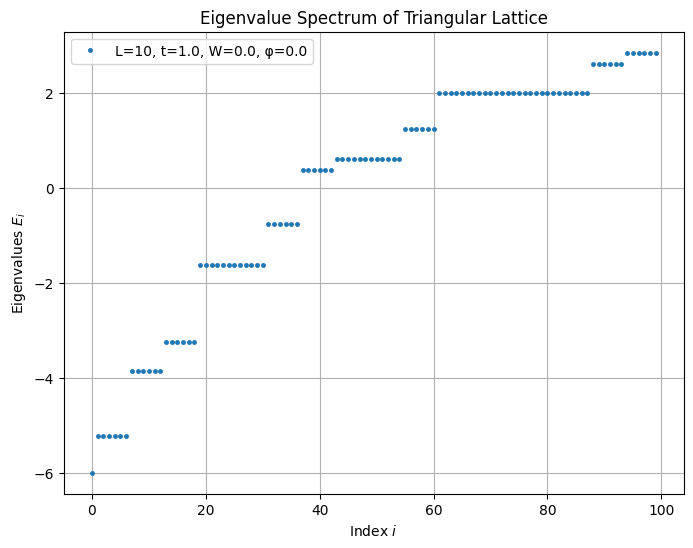

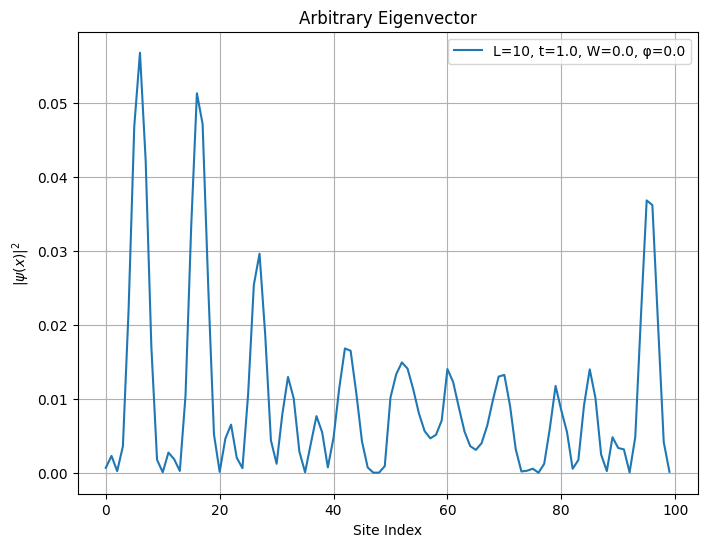

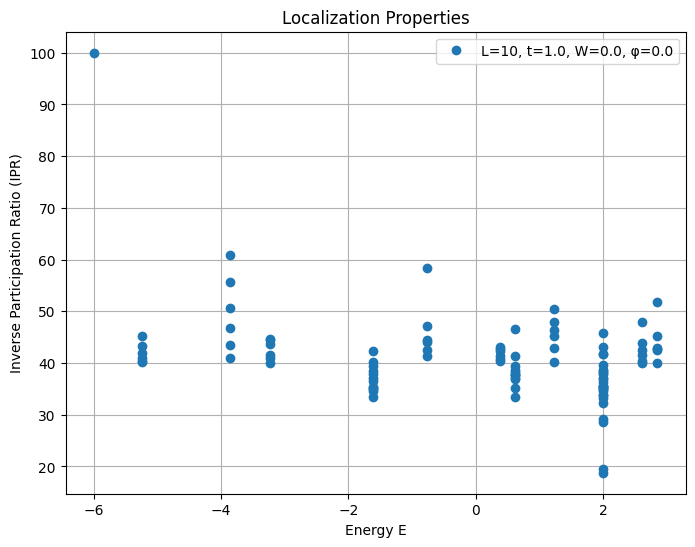

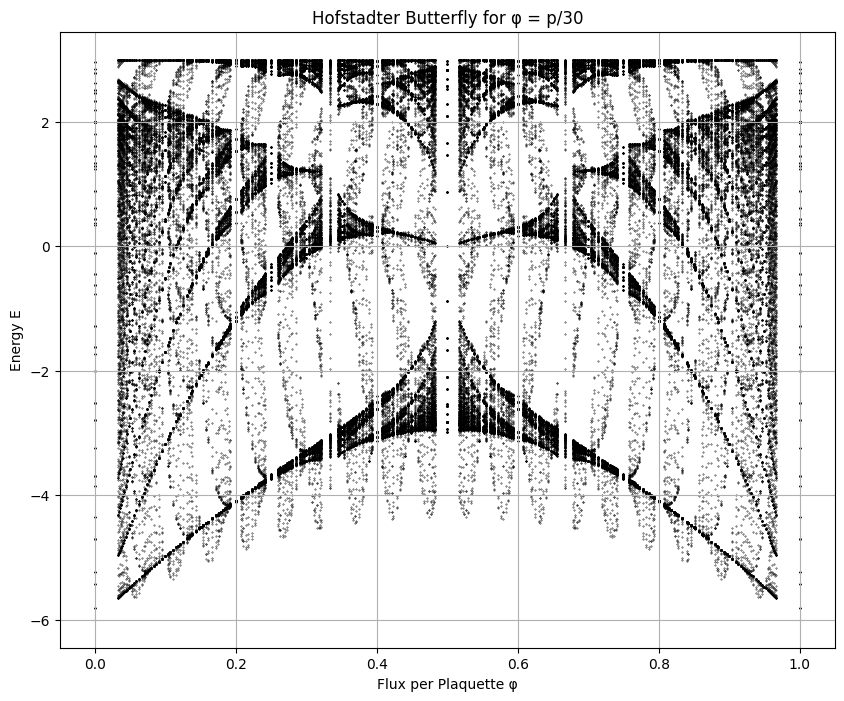

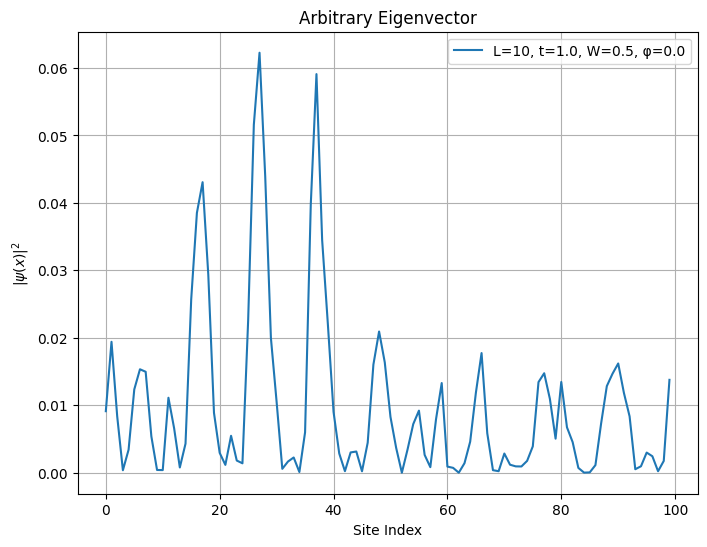

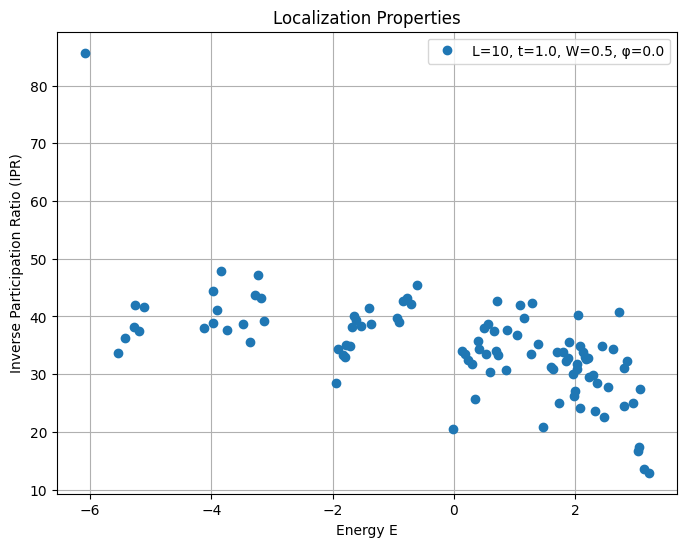

In [2]:
# Basic eigenvalue spectrum without disorder or magnetic field
model = Triangular_Hamiltonian(length=10, t=1.0, W=0.0, phi=0.0, q=20)
model.construct_hamiltonian()
model.plot_evals()
model.plot_evec()
model.plot_pr()

# Hofstadter butterfly with no disorder
model = Triangular_Hamiltonian(length=20, t=1.0, W=0.0, phi=0.0, q=30)
model.construct_hamiltonian()
model.plot_hofstadter_butterfly()

# Anderson localization effects
model = Triangular_Hamiltonian(length=10, t=1.0, W=0.5, phi=0.0, q=20)
model.construct_hamiltonian()
model.plot_evec()  # Shows localized eigenstates
model.plot_pr()    # Shows localization via participation ratio

Kagome Lattice

In [4]:
class Kagome_Hamiltonian:
    """ Kagome lattice hamiltonian class """
    def __init__(self, length: int, t: float, disorder: float, phi: float):
        self.L = length  # Set hamiltonian dimensions
        # For Kagome lattice, we need 3 sites per unit cell
        self.matrix = np.zeros((3 * self.L * self.L, 3 * self.L * self.L), dtype=complex)
        self.disorder = disorder  # Set disorder parameter
        self.t = t  # Set hopping amplitude
        self.phi = phi  # Set magnetic field parameter

        # Initialize the block matrices for the 3x3 structure
        self.AA = np.zeros((self.L * self.L, self.L * self.L), dtype=complex)
        self.BB = np.zeros((self.L * self.L, self.L * self.L), dtype=complex)
        self.CC = np.zeros((self.L * self.L, self.L * self.L), dtype=complex)
        self.AB = np.zeros((self.L * self.L, self.L * self.L), dtype=complex)
        self.BC = np.zeros((self.L * self.L, self.L * self.L), dtype=complex)
        self.CA = np.zeros((self.L * self.L, self.L * self.L), dtype=complex)

    def disorder_setter(self, block, i):
        # Incorporate the disorder parameter into matrix elements for each sublattice
        eps_i = self.disorder * (2 * np.random.rand() - 1)
        block[i, i] = eps_i

    def construct_blocks(self, phi=None):
        phi_use = self.phi if phi is None else phi

        for i, j in np.ndindex((self.L, self.L)):
            idx = i * self.L + j

            # Nearest neighbor connections between sublattices
            # A to B connections
            if j < self.L - 1:
                self.AB[idx, idx + 1] = self.t
            if i < self.L - 1:
                phase = np.exp(1j * 2 * np.pi * phi_use * i)
                self.AB[idx, idx + self.L] = self.t * phase

            # B to C connections
            if j < self.L - 1:
                phase = np.exp(1j * 2 * np.pi * phi_use * i)
                self.BC[idx, idx + 1] = self.t * phase
            if i < self.L - 1:
                self.BC[idx, idx + self.L] = self.t

            # C to A connections (completing the triangle)
            if j < self.L - 1:
                self.CA[idx, idx + 1] = self.t
            if i < self.L - 1:
                phase = np.exp(1j * 2 * np.pi * phi_use * i)
                self.CA[idx, idx + self.L] = self.t * phase

            # Add disorder if specified
            if self.disorder != 0:
                self.disorder_setter(self.AA, idx)
                self.disorder_setter(self.BB, idx)
                self.disorder_setter(self.CC, idx)

    def construct_matrix(self, phi=None):
        # Construct the block matrices
        self.construct_blocks(phi)

        # Combine blocks into full Hamiltonian
        top = np.concatenate((self.AA, self.AB, self.CA.conjugate()), axis=1)
        middle = np.concatenate((self.AB.conjugate(), self.BB, self.BC), axis=1)
        bottom = np.concatenate((self.CA, self.BC.conjugate(), self.CC), axis=1)

        self.H = np.concatenate((top, middle, bottom), axis=0)

        # Ensure Hermiticity
        self.H = (self.H + self.H.conjugate().T) / 2

        # Calculate eigenvalues and eigenvectors
        self.evals, self.evecs = np.linalg.eigh(self.H)

    """ basic plotting functions """

    def plot_evals(self):
        plt.plot(self.evals, '.')
        plt.ylabel(r'$E_i$')
        plt.xlabel(r'$i$')
        plt.show()

    def plot_evec(self):
        self.psi = self.evecs[:,3*self.L//2]  # Middle of the spectrum
        plt.plot(np.abs(self.psi)**2)
        plt.xlabel('x')
        plt.ylabel(r'$ |\psi(x)|^2$')
        plt.show()

    def plot_evec_disorder(self):
        self.psi = self.evecs[:,3*self.L//2]
        fig, ax = plt.subplots(2,1,sharex=True)
        ax[0].plot(np.abs(self.psi)**2)
        ax[1].semilogy(np.abs(self.psi)**2)
        ax[1].set_xlabel('x')
        ax[0].set_ylabel(r'$ |\psi(x)|^2$')
        ax[1].set_ylabel(r'$ |\psi(x)|^2$')
        plt.show()

    def plot_pr(self):
        self.PR = 1./np.sum(np.abs(self.evecs)**4, axis=0)
        plt.plot(self.evals, self.PR, 'o')
        plt.xlabel('E')
        plt.ylabel('PR(E)')
        plt.show()

    """ hofstader butterfly support """

    def plot_butterfly(self):
        plt.figure(figsize=(8, 6))
        for p in range(1, self.L + 1):
            for q in range(1, self.L + 1):
                if q > p and gcd(p, q) == 1:
                    nphi = p / q
                    self.construct_matrix(phi=nphi)
                    plt.plot(np.full_like(self.evals, nphi), self.evals, 'o',
                            c="black", markersize=0.1)

        plt.xlabel(r'$\phi$', fontsize=15)
        plt.ylabel(r'$E$', fontsize=15)
        plt.title(r'Hofstadter Butterfly for $L=' + str(self.L) + '$', fontsize=15)
        plt.grid()
        plt.show()

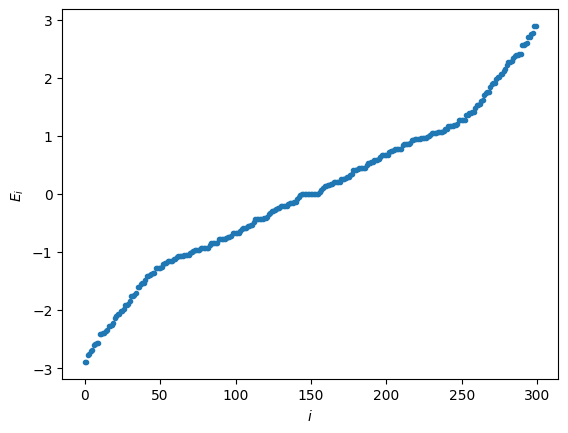

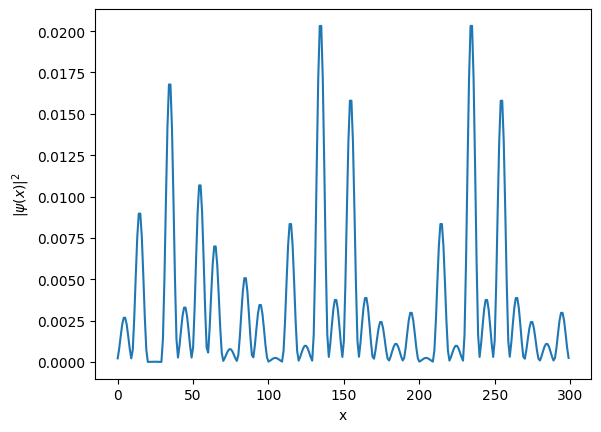

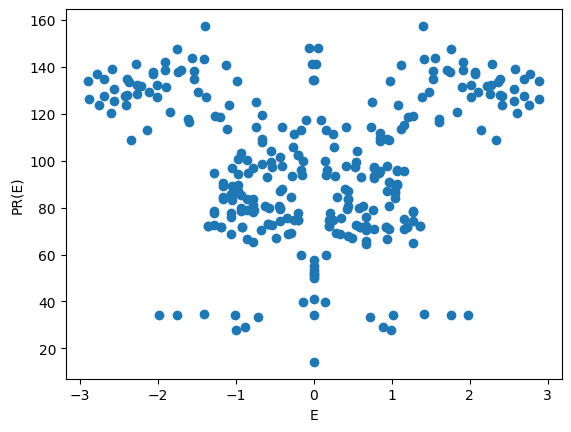

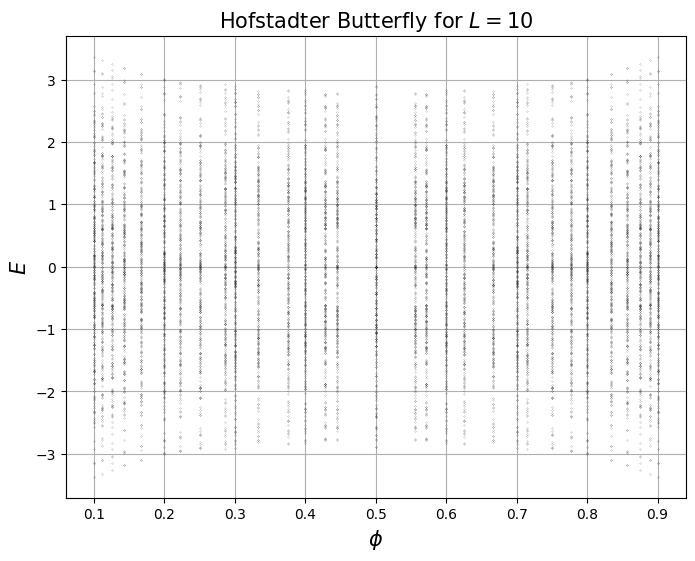

In [5]:
# Example 1 - repeated for kagome lattice
kagome = Kagome_Hamiltonian(length=10, t=1.0, disorder=0.0, phi=0.5)
kagome.construct_matrix()
kagome.plot_evals()
kagome.plot_evec()
kagome.plot_pr()
kagome.plot_butterfly()

Oblique Lattice 